# Project Statement:

## Marina Pier Inc. is leveraging technology to automate their operations on the San Francisco port.

## The company’s management has set out to build a bias-free/ corruption-free automatic system that reports & avoids faulty situations caused by human error. Examples of human error include misclassifying the correct type of boat. The type of boat that enters the port region is as follows

* Buoy
* Cruise_ship
* Ferry_boat
* Freight_boar
* Gondola
* Inflatable_boat
* Kayak
* Paper_boat
* Sailboat

## Marina Pier wants to use Deep Learning techniques to build an automatic reporting system that recognizes the boat. The company is also looking to use a transfer learning approach of any lightweight pre-trained model in order to deploy in mobile devices.

## As a deep learning engineer, our task is to:

1. Build a CNN network to classify the boat.
2. Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. We can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API.

# Dataset and Data Description: 

## The dataset folder is called Automating_Port_Operations_dataset 

## The dataset contains images of 9 types of boats. It contains a total of 1162 images. The training images are provided in the directory of the specific class itself. 
## Classes:
* ferry_boat
* gondola
* sailboat
* cruise_ship
* kayak
* inflatable_boat
* paper_boat
* buoy
* freight_boat




# 1. Building a CNN to classify the boat

In [1]:
#pip install tensorflow

# Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

import os
import PIL
from PIL import Image
import pathlib
import glob

2024-09-25 20:33:02.167297: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


# Defining the path for the dataset and displaying first image from each image directory

['buoy', 'gondola', 'ferry_boat', 'cruise_ship', 'freight_boat', 'kayak', 'sailboat', 'inflatable_boat', 'paper_boat']
/Users/master/GitProjects/BoatClassification_CNN_and_TransferLearning_Project/Automating_Port_Operations_dataset

Displaying first image from folder: buoy


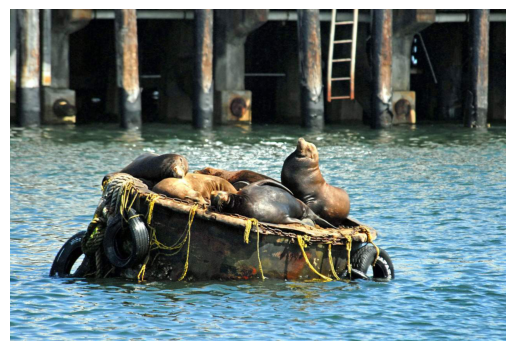

Displaying first image from folder: gondola


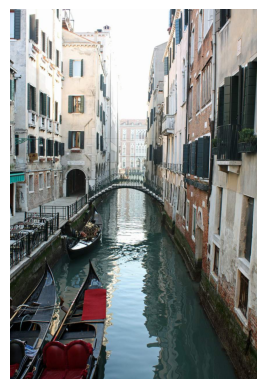

Displaying first image from folder: ferry_boat


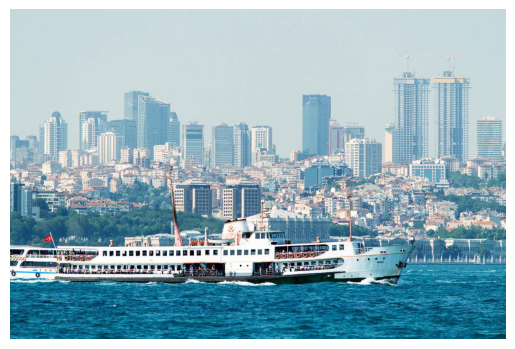

Displaying first image from folder: cruise_ship


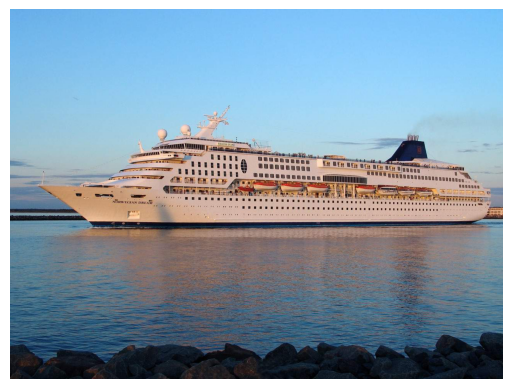

Displaying first image from folder: freight_boat


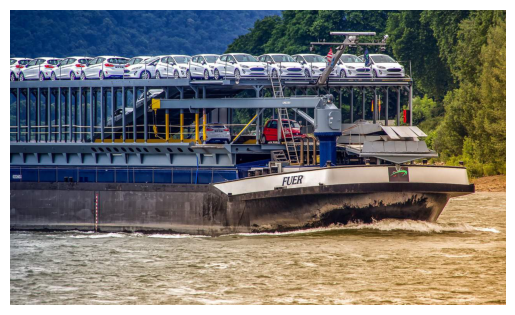

Displaying first image from folder: kayak


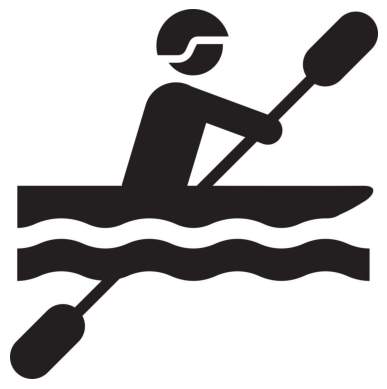

Displaying first image from folder: sailboat


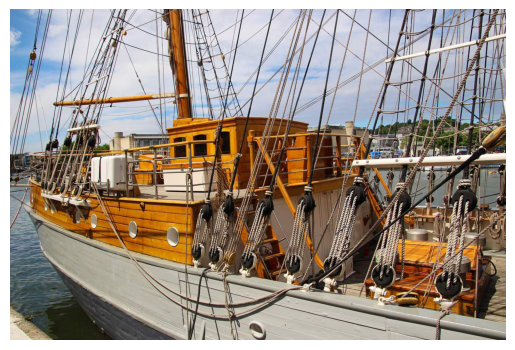

Displaying first image from folder: inflatable_boat


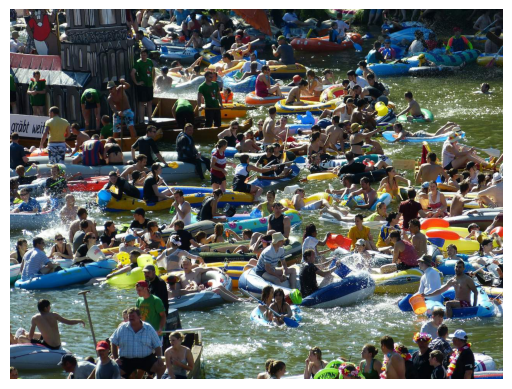

Displaying first image from folder: paper_boat


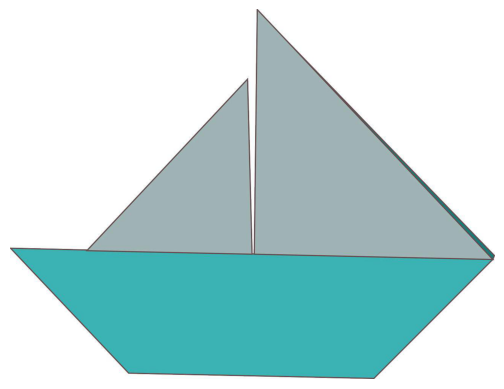

In [3]:

# Defining base path where dataset is located
data_dir = os.path.join(os.getcwd(), 'Automating_Port_Operations_dataset')

# Getting only visible directories (exclude hidden directories like .DS_Store)
image_dirs = [d for d in os.listdir(data_dir) if not d.startswith('.')]

print(image_dirs) # List of directories in the dataset
print(data_dir) # Path to parent directory of dataset
print()

# Function to display single image given an image path
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
# Displaying the first image in each directory in image_dirs
for d in image_dirs:
    image_path = os.path.join(data_dir, d, os.listdir(os.path.join(data_dir, d))[0])
    print(f"Displaying first image from folder: {d}")
    display_image(image_path)


# Creating training and datasets with following characteristics:

* Dataset will be split into train and test in the ratio 80:20, with shuffle and random state = 43
* We'll use tf.keras.preprocessing.image_dataset_from_directory to load the train and test datasets with data normalization

* We'll load train, validation and test dataset in batches of 32 using the function initialized in step above

## Dataset Split into Training, Validation and Testing with normalzation

## Visualizing images from training dataset

# Create Convolutional Neural Network Model

# We'll build a CNN network with Keras with the following layers:

### We'll do data augmentation issue to balance the data as we have some images that are 

### Conv2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D
### Conv2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D
### GLobalAveragePooling2D layer
### Dense layer with 128 neurons and activation relu
### Dense layer with 128 neurons and activation relu
### Dense layer with 9 neurons and activation softmax.


In [4]:


# Set parameters
batch_size = 32
img_height = 150
img_width = 150
AUTOTUNE = tf.data.AUTOTUNE

# Define data directory
data_dir = os.path.join(os.getcwd(), 'Automating_Port_Operations_dataset')

# Create training dataset
train_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 80% for training, 20% for validation + test
    subset="training", # Use the training subset
    seed=43, # Seed for reproducibility
    image_size=(img_height, img_width), # Resize images to 150x150
    batch_size=batch_size, # Use a batch size of 32
    shuffle=True # Shuffle the training dataset so that the model does not overfit to the order of the images
)

# Create validation and test datasets
val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, # 20% for validation + test 
    subset="validation", # Use the validation subset
    seed=43, # Seed for reproducibility
    image_size=(img_height, img_width), # Resize images to 150x150
    batch_size=batch_size # Use a batch size of 32
)

class_names = train_val_ds.class_names  # Get class names    
print(f"Class names: {class_names}")

# Further split val_test_ds into validation and test sets
val_batches = int(0.5 * len(val_test_ds)) # Split the validation and test sets in half

# Isolate the validation and test datasets
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

# Normalize the pixel values
def normalize_img(image, label):
    image = image / 255.0
    return image, label

def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=len(class_names))  # One-hot encode the labels (convert to binary vectors) in order to use categorical crossentropy loss
    return image, label

# Apply this to the datasets
train_ds = train_val_ds.map(lambda x, y: (x / 255.0, tf.one_hot(y, len(class_names)))).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # Cache, shuffle, and prefetch the training dataset
val_ds = val_ds.map(lambda x, y: (x / 255.0, tf.one_hot(y, len(class_names)))).cache().prefetch(buffer_size=AUTOTUNE) # Cache and prefetch the validation dataset
test_ds = test_ds.map(lambda x, y: (x / 255.0, tf.one_hot(y, len(class_names)))).cache().prefetch(buffer_size=AUTOTUNE) # Cache and prefetch the test dataset






Found 1162 files belonging to 9 classes.
Using 930 files for training.
Found 1162 files belonging to 9 classes.
Using 232 files for validation.
Class names: ['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat']


## Create model

In [5]:


input_shape = (img_height, img_width, 3) # Define the input shape because we are using a Sequential model

model = models.Sequential([
    layers.Input(shape=input_shape),  # Explicit Input layer to define the input shape
    layers.Conv2D(32, (3, 3), activation='relu'), # Convolutional layer with 32 filters, 3x3 kernel size, and ReLU activation
    layers.MaxPooling2D(), # Max pooling layer
    layers.Conv2D(32, (3, 3), activation='relu'), # Convolutional layer with 32 filters, 3x3 kernel size, and ReLU activation
    layers.MaxPooling2D(), # Max pooling layer
    layers.GlobalAveragePooling2D(), # Global average pooling layer which averages the values in the feature maps
    layers.Flatten(), # Flatten layer to flatten the output of the previous layer
    layers.Dense(128, activation='relu'), # Dense layer with 128 units and ReLU activation
    layers.Dense(128, activation='relu'), # Dense layer with 128 units and ReLU activation
    layers.Dense(len(class_names), activation='softmax') # Output layer with units equal to the number of classes and softmax activation
])

model.summary() # Display the model summary



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,041 (125.16 KB)

 Trainable params: 32,041 (125.16 KB)

 Non-trainable params: 0 (0.00 B)

## Compile the model

In [6]:
model.compile(
    optimizer='adam', # Adam optimizer
    loss='categorical_crossentropy', # Categorical crossentropy loss
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()] # Accuracy, precision, and recall metrics
)



## Train the model

In [7]:
# Train the model
# Set the number of epochs to 20
epochs = 20

# Train the model
history = model.fit(
    train_ds, # Use the training dataset for training
    validation_data=val_ds,  # Use the validation dataset for validation during training
    epochs=epochs # Set the number of epochs
)



Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.2318 - loss: 2.0656 - precision: 0.4302 - recall: 0.0046 - val_accuracy: 0.3281 - val_loss: 1.7950 - val_precision: 0.8000 - val_recall: 0.0625
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.3430 - loss: 1.7983 - precision: 0.6912 - recall: 0.0456 - val_accuracy: 0.3281 - val_loss: 1.7884 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.3430 - loss: 1.8121 - precision: 0.5323 - recall: 0.0029 - val_accuracy: 0.3281 - val_loss: 1.7832 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.3412 - loss: 1.8136 - precision: 0.8125 - recall: 0.0083 - val_accuracy: 0.3281 - val_loss: 1.7656 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.3488 - loss: 1.7829 - precision: 0.3853 - recall: 0.0070 - val_accurac

## Plot Training and Validation Accuracy/Loss over epochs

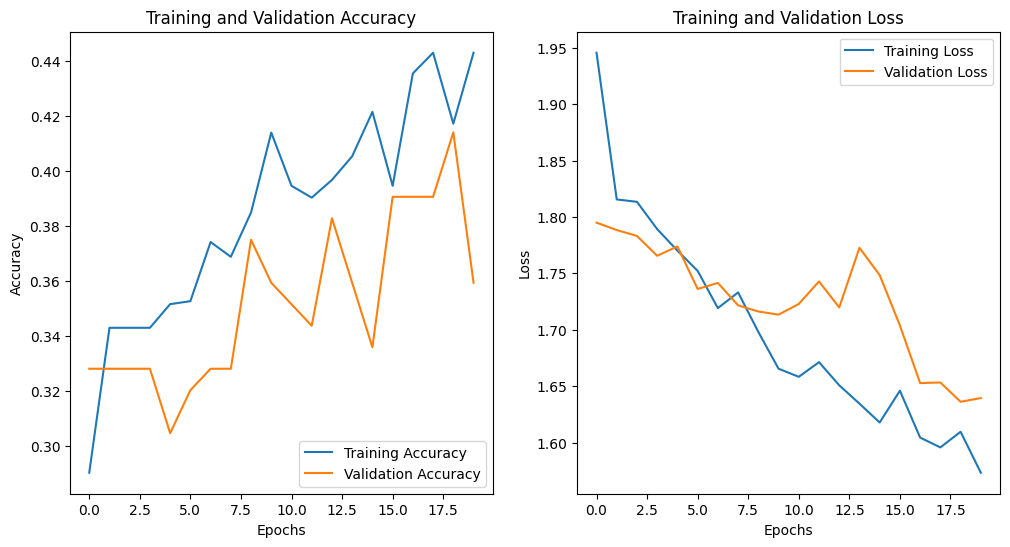

In [8]:
# Plot the training and validation accuracy/loss over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs) # Define the range of epochs

plt.figure(figsize=(12, 6)) # Set the figure size

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


## Model Evaluation

In [9]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_ds)

# Print test loss, accuracy, precision, and recall
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')




4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3785 - loss: 1.5920 - precision: 0.5166 - recall: 0.1651
Test Loss: 1.5202301740646362
Test Accuracy: 0.39423078298568726
Test Precision: 0.5454545617103577
Test Recall: 0.17307692766189575


## Evaluate model on test images and print test loss and accuracy

In [38]:


# Generate predictions from the model on the test set
y_pred = []
y_true = []

# Iterate over the test dataset to get true labels and predicted labels
for images, labels in test_ds: # Since batch size is 32, this will iterate over the entire test set with is about 50% of the validation set (25% of the entire dataset)
    predictions = model.predict(images) # Get the predicted probabilities
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert predicted probabilities to class labels
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot encoded labels back to integers



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


2024-09-26 10:22:15.125119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Plot heatmap of confusion matrix and print classification report

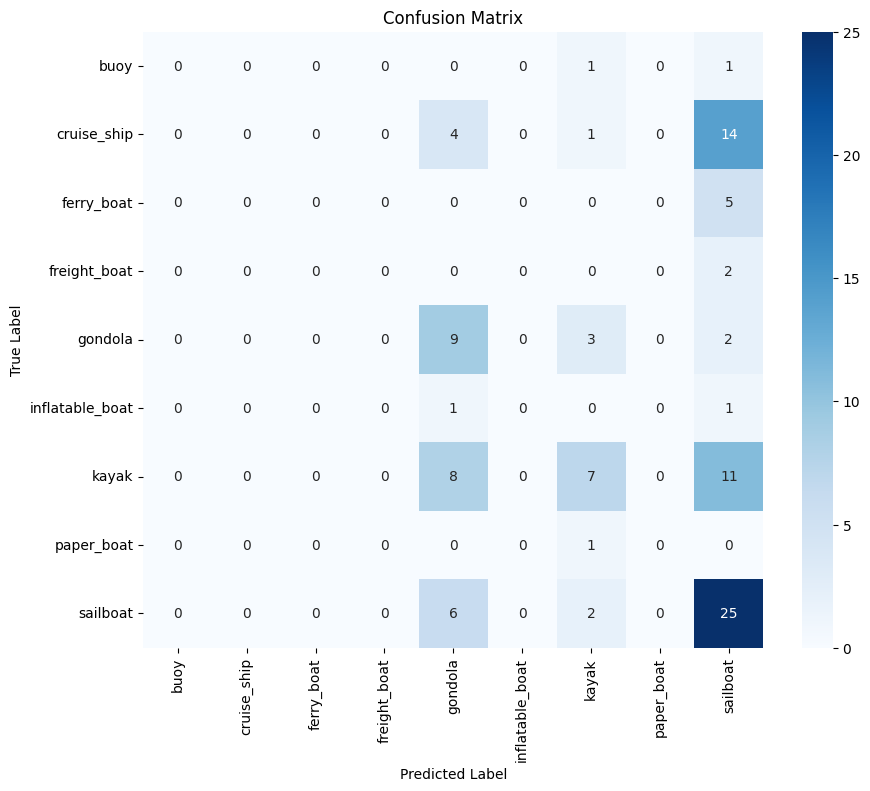

Classification Report:
                 precision    recall  f1-score   support

           buoy       0.00      0.00      0.00         2
    cruise_ship       0.00      0.00      0.00        19
     ferry_boat       0.00      0.00      0.00         5
   freight_boat       0.00      0.00      0.00         2
        gondola       0.32      0.64      0.43        14
inflatable_boat       0.00      0.00      0.00         2
          kayak       0.47      0.27      0.34        26
     paper_boat       0.00      0.00      0.00         1
       sailboat       0.41      0.76      0.53        33

       accuracy                           0.39       104
      macro avg       0.13      0.19      0.14       104
   weighted avg       0.29      0.39      0.31       104



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=class_names))


# SUMMARY FOR FIRST CNN RESULTS:

## Training and Validation Accuracy/Loss

### Training and Validation Accuracy:

### Training Accuracy: The model's training accuracy shows a gradual increase over time, reaching around 0.44 by the end of training, indicating that the model is learning from the training data.
### Validation Accuracy: The validation accuracy fluctuates more than the training accuracy. At certain epochs, validation accuracy increases, but it generally remains lower than the training accuracy and ends at around 0.38, suggesting some degree of overfitting where the model learns the training data better than it generalizes to unseen data.
### Interpretation: There is some improvement in validation accuracy over time, but the model's capacity to generalize remains limited. The large fluctuations in validation accuracy might indicate that the model has difficulties in handling the diversity of the validation set.

### Training Loss: The training loss decreases steadily from around 1.95 to 1.59, indicating that the model is minimizing error on the training set as expected.
### Validation Loss: The validation loss decreases initially but fluctuates more after about 5 epochs. This indicates that the model struggles with generalization after an initial improvement.
### Interpretation: The validation loss and training loss start to diverge slightly, especially toward the end of training. This is a potential sign of overfitting: the model is improving on the training set but not as much on the validation set.

### Evaluation on the Test Set

### Test Accuracy: 0.39 (39%)
### Test Loss: 1.52
### Test Precision: 0.55
### Test Recall: 0.17

### Observations:
### Accuracy: The test accuracy of 39% indicates that the model is not performing well on unseen data. This low accuracy suggests the model has not learned enough to make reliable predictions.
### Precision: Precision of 0.55 indicates that when the model predicts a class, it is correct only 55% of the time. This is better than the recall but still low.
### Recall: The recall value of 0.17 is particularly poor, indicating that the model misses many true positives, especially in minority classes.

## Analysis of the Confusion Matrix and Classification Report

### The confusion matrix shows how the model performed in predicting each class, with the following observations:

### Diagonal Elements: These represent the correct predictions for each class (true positives). For example:
### Sailboat: 25 correct predictions out of 33 actual sailboat images.
### Gondola: 9 correct predictions out of 14 actual gondola images.
### Kayak: 7 correct predictions out of 26 actual kayak images.
### Off-Diagonal Elements: These indicate misclassifications. For example:
### Cruise Ship: Many images were misclassified as "sailboat" (14 instances).
### Kayak: Several kayak images were misclassified as "sailboat" (11 instances).
### Gondola: Some gondola images were misclassified as "kayak" (3 instances).
### The confusion matrix shows that the model struggles with certain classes, particularly differentiating between similar boat types (like "kayak" and "sailboat"). It performs well for classes like "sailboat" but has difficulty distinguishing between the other classes.

## Interpretations:

### Low Precision and Recall for Several Classes:
### Cruise Ship, Ferry Boat, Freight Boat, Buoy, Inflatable Boat, Paper Boat: Precision, recall, and F1-score are all 0.00, meaning the model was unable to correctly predict any of these images.
### This suggests that the model cannot effectively distinguish these classes, possibly due to insufficient training examples or high similarity between these classes and others.
### Better Performance for Gondola, Kayak, and Sailboat:
### Gondola: Has a reasonable recall of 0.64, meaning the model can correctly identify 64% of gondola images.
### Sailboat: The best performing class, with 0.76 recall and 0.41 precision, but it still misclassifies many other images as "sailboat".
### Kayak: Has a moderate recall of 0.27 but is frequently confused with sailboats.
### Overall Metrics:
### Accuracy: The overall accuracy of the model is 0.39, meaning the model correctly classifies 39% of all test samples.
### Macro Avg: Precision, recall, and F1-score are low (0.13, 0.19, and 0.14 respectively), indicating poor performance across most classes.
### Weighted Avg: Shows that the model's performance is skewed by the larger classes (like sailboat), leading to slightly higher weighted averages but still below optimal (0.29, 0.39, and 0.31).

# 2. Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning, by using MobileNetV2, a lightweight pre-trained model using Keras API as the initial (first) layer.

## Set parameters
## Do one_hot_encoding for labels
## Split Dataset (Train/Test 70:30) using tf.keras.preporcessing.image_dataset_from_directory to load and split the dataset, shuffle the data, and set a random seed to ensure consistency.
## Normalize dataset pixel values and one-hot encode labels

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import os

# Set parameters
batch_size = 32
img_height = 224  # Updated to match MobileNetV2 expected input size
img_width = 224
AUTOTUNE = tf.data.AUTOTUNE

# Define data directory
data_dir = os.path.join(os.getcwd(), 'Automating_Port_Operations_dataset')

# Function to normalize the pixel values and one-hot encode labels
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=9)  # Assuming 9 classes in the dataset
    image = image / 255.0  # Normalize the image to the range [0, 1]
    return image, label

# Load the dataset and split it into train and validation (70% train, 30% validation)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, # Load the dataset from the specified directory
    validation_split=0.3, # 70% for training, 30% for validation + test
    subset="training", # Use the training subset
    seed=1, # Seed for reproducibility
    image_size=(img_height, img_width),  # Set to 224x224 to match MobileNetV2
    batch_size=batch_size, # Use a batch size of 32
    shuffle=True # Shuffle the training dataset
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, # Load the dataset from the specified directory
    validation_split=0.3, # 30% for validation + test
    subset="validation", # Use the validation subset
    seed=1, # Seed for reproducibility
    image_size=(img_height, img_width),  # Set to 224x224 to match MobileNetV2
    batch_size=batch_size   # Use a batch size of 32
)

# Apply normalization and one-hot encoding to the training dataset
train_ds = train_ds.map(one_hot_encode).cache().prefetch(buffer_size=AUTOTUNE)

# Further split validation set into 50% validation and 50% test set
val_batches = int(0.5 * len(val_test_ds))  # Calculate half the number of validation batches

val_ds = val_test_ds.take(val_batches)  # Take the first half as validation
test_ds = val_test_ds.skip(val_batches)  # Skip the first half and use the rest as test

# Apply normalization and one-hot encoding to the validation and test datasets
val_ds = val_ds.map(one_hot_encode).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(one_hot_encode).cache().prefetch(buffer_size=AUTOTUNE)


Found 1162 files belonging to 9 classes.
Using 814 files for training.
Found 1162 files belonging to 9 classes.
Using 348 files for validation.


## Building the CNN with Transfer Learning Using MobileNetV2

In [32]:

# Load the MobileNetV2 pre-trained model with weights from ImageNet
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,  # We don't need the top layers (classification layers)
                         weights='imagenet')  # Load pre-trained ImageNet weights

# Freeze the base model
base_model.trainable = False  # We freeze the base model to keep the pre-trained weights

# Build the CNN model
model = models.Sequential([
    base_model,  # Add MobileNetV2 as the base layer
    layers.GlobalAveragePooling2D(),  # Reduce dimensionality
    layers.Dropout(0.2),  # Dropout for regularization
    layers.Dense(256, activation='relu'),  # Dense layer with 256 units and ReLU activation
    layers.BatchNormalization(),  # Batch normalization layer
    layers.Dropout(0.1),  # Dropout for regularization
    layers.Dense(128, activation='relu'),  # Dense layer with 128 units and ReLU activation
    layers.BatchNormalization(),  # Batch normalization layer
    layers.Dropout(0.1),  # Dropout for regularization
    layers.Dense(9, activation='softmax')  # Assuming 9 output classes (one-hot encoded)
])


## Compile the model

In [33]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use categorical crossentropy for one-hot encoded labels
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


# Train the model


In [34]:
# Early stopping callback to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping]
)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 584ms/step - accuracy: 0.4868 - loss: 1.7781 - precision_5: 0.6428 - recall_5: 0.3617 - val_accuracy: 0.7563 - val_loss: 0.8063 - val_precision_5: 0.9279 - val_recall_5: 0.6438
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 525ms/step - accuracy: 0.8694 - loss: 0.4226 - precision_5: 0.9193 - recall_5: 0.8265 - val_accuracy: 0.8000 - val_loss: 0.6519 - val_precision_5: 0.9084 - val_recall_5: 0.7437
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 523ms/step - accuracy: 0.9263 - loss: 0.2426 - precision_5: 0.9547 - recall_5: 0.8923 - val_accuracy: 0.8188 - val_loss: 0.6252 - val_precision_5: 0.8864 - val_recall_5: 0.7312
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 527ms/step - accuracy: 0.9604 - loss: 0.1614 - precision_5: 0.9796 - recall_5: 0.9488 - val_accuracy: 0.8250 - val_loss: 0.6071 - val_precision_5: 0.8806 - val_recall_5: 0.7375
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 534ms/step - accuracy: 0.9710 - loss: 0.1103 - precision_5: 0.9767 - recall_5: 0.9

# Evaluate the model for test loss, accuracy, precision and recall

In [35]:
# Evaluate the model on the validation set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_ds)

# Print evaluation results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 433ms/step - accuracy: 0.8316 - loss: 0.5457 - precision_5: 0.8866 - recall_5: 0.7893
Test Loss: 0.5478175282478333
Test Accuracy: 0.8297872543334961
Test Precision: 0.886904776096344
Test Recall: 0.792553186416626


# Visualize validation accuracy and loss

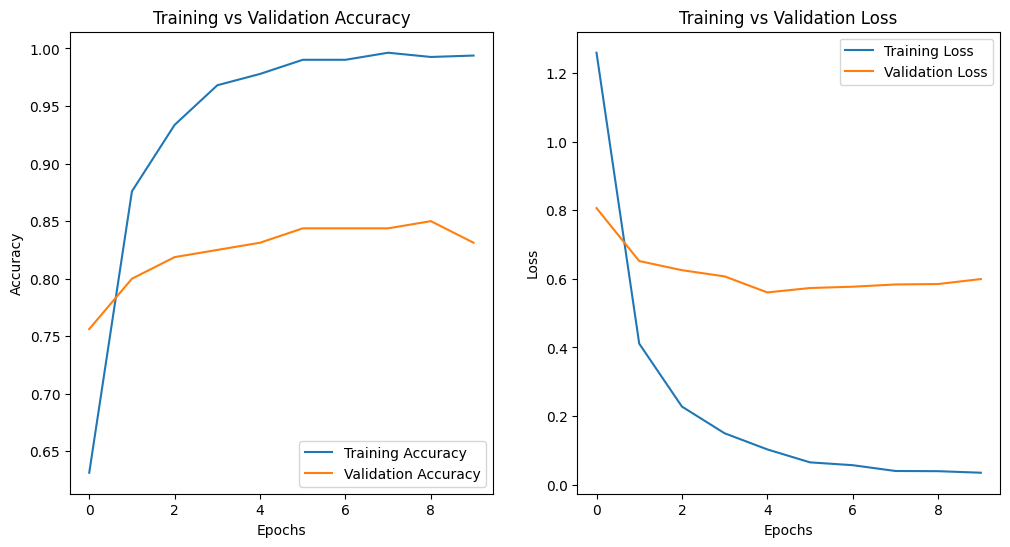

In [36]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()

# Compute confusion matrix and generate heatmap

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


2024-09-26 01:59:23.024542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


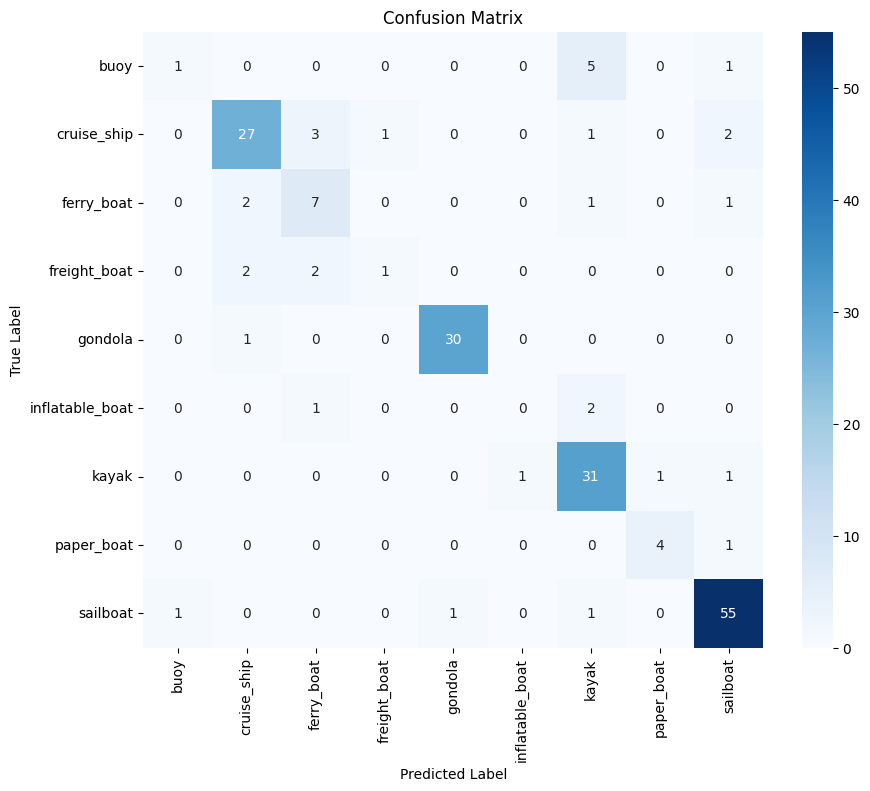

Classification Report:
                 precision    recall  f1-score   support

           buoy       0.50      0.14      0.22         7
    cruise_ship       0.84      0.79      0.82        34
     ferry_boat       0.54      0.64      0.58        11
   freight_boat       0.50      0.20      0.29         5
        gondola       0.97      0.97      0.97        31
inflatable_boat       0.00      0.00      0.00         3
          kayak       0.76      0.91      0.83        34
     paper_boat       0.80      0.80      0.80         5
       sailboat       0.90      0.95      0.92        58

       accuracy                           0.83       188
      macro avg       0.65      0.60      0.60       188
   weighted avg       0.81      0.83      0.81       188



In [37]:
# Compute confusion matrix and plot it as a heatmap
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Generate predictions from the model on the test set
y_pred = []
y_true = []

# Iterate over the test dataset to get true labels and predicted labels
for images, labels in test_ds:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert predicted probabilities to class labels
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot encoded labels back to integers

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=class_names))




# SUMMARY FOR SECOND CNN RESULTS WITH PRE-TRAINED MODEL:

### Training Accuracy and loss: The training accuracy rapidly increases and plateaus near 1.0 (100%) within 3-4 epochs, suggesting that the model is fitting very well to the training data.
### The training loss drops steeply, reaching near zero by the end of training. This suggests that the model has learned the training data almost perfectly.

### Validation Accuracy and loss: The validation accuracy plateaus around 0.83 (83%) by the end of training, which is a good result, but there is a clear gap between training and validation accuracy.
### The validation loss decreases steadily but starts to flatten out after a few epochs and even increases slightly in later epochs, indicating overfitting to some extent.

### Interpretation: The training accuracy is much higher than validation accuracy, and the validation loss is higher than the training loss, which typically indicates overfitting. The model is fitting the training data very well but struggles to generalize to new data (as seen with the validation set).
### However, the validation performance is still quite strong with an accuracy of 83%.

## Evaluation on the Test Set

### Test Accuracy: 0.83 (83%)
### Test Loss: 0.55
### Test Precision: 0.89 (~89%)
### Test Recall: 0.79 (~79%)

## Observations:
### Accuracy: The test accuracy of 83% is consistent with the validation accuracy, indicating that the model's performance is quite stable across validation and test data.
### Precision: A high precision value of 0.89 shows that the model is making accurate positive predictions across the various classes.
### Recall: The recall value of 0.79 is slightly lower, indicating that the model is missing some of the actual positive instances in certain classes.

## Classification Report:

### Buoy: Poor performance with a precision of 0.50 and recall of 0.14. This suggests that the model is struggling with this class, likely due to class imbalance or the complexity of the class.
### Cruise Ship: Good performance with precision of 0.84 and recall of 0.79.
### Ferry Boat: Precision of 0.54 and recall of 0.64 is decent but not outstanding.
### Freight Boat: Similar to "buoy," this class is underperforming with a recall of only 0.20.
### Gondola: Excellent performance with precision and recall both around 0.97.
### Inflatable Boat: 0.00 across precision, recall, and F1-score indicates that the model is unable to classify this class. Likely due to a very small number of samples (support = 3).
### Kayak: Good performance with 0.76 precision and 0.91 recall, suggesting that most kayak instances are correctly identified.
### Paper Boat: High performance, though the class size is very small (support = 5).
### Sailboat: Best-performing class with 0.90 precision and 0.95 recall, showing the model is doing very well on this class.

### Macro Average:
### The macro average for precision, recall, and F1-score hovers around 0.60, showing the model is not performing equally across all classes. Some classes are underrepresented or more difficult to classify.
### Weighted Average:
### The weighted average shows better results, close to the test accuracy (~0.81 for precision and F1-score). This reflects that the model performs better on the larger, more represented classes, like "sailboat" and "gondola," which dominate the test set.

## Results:

### Good Overall Performance:
### The model achieves a strong test accuracy of 83% and high precision (~89%) and recall (~79%), showing that it performs well overall.
### Class Imbalance:
### Classes like "buoy", "freight boat", and "inflatable boat" perform poorly. These classes have very few examples in the dataset, making it difficult for the model to learn meaningful patterns.
### Techniques like class weighting or oversampling could help improve performance on these minority classes.
### Overfitting:
### The model seems to overfit the training data to some extent, as seen by the gap between training and validation accuracy and loss. This suggests that the model could benefit from further regularization (e.g., more dropout, L2 regularization) or data augmentation.
### Strong Performance on Dominant Classes:
### The model performs exceptionally well on classes like "sailboat", "gondola", and "kayak", which likely have a larger number of examples in the training data.

# Conclusion

### The pre-trained MobileNetV2 model significantly outperformed the original CNN model across most metrics. The pre-trained model achieved a test accuracy of 83%, compared to the original CNN's 39%, and demonstrated higher precision (0.89 vs. 0.55) and recall (0.79 vs. 0.17). This suggests that the MobileNetV2 model, with its pre-learned features from ImageNet, was able to generalize much better to the dataset, particularly on classes like "sailboat", "gondola", and "kayak", where the original CNN struggled. The original CNN suffered from severe overfitting, low performance on minority classes, and poor generalization, while the pre-trained model handled these challenges more effectively, though it still faced difficulty with underrepresented classes like "buoy" and "inflatable boat". Overall, leveraging the pre-trained MobileNetV2 architecture offered clear advantages in terms of model performance and robustness.






